# Autoencoder + Transformer Hybrid Model with SHAP Analysis

In [2]:
# Import Required Libraries
# Ensure TensorFlow is installed in your environment: pip install tensorflow numpy pandas scikit-learn matplotlib seaborn shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap

2025-01-16 14:46:26.179924: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 14:46:26.181038: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 14:46:26.203735: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 14:46:26.204285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 14:46:26.595953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Step 1: Data Loading

In [3]:
# Column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

## Step 2: Data Preprocessing

In [4]:
# Drop 'difficulty_degree' column as it does not add value
del train["difficulty_degree"]
del test["difficulty_degree"]

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Map 'labels' column to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## Step 3: Define Autoencoder + Transformer Hybrid Model

In [5]:
# Autoencoder Component
def build_autoencoder(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation="relu")(inputs)
    encoded = layers.Dense(64, activation="relu")(encoded)
    encoded = layers.Dense(32, activation="relu")(encoded)
    decoded = layers.Dense(64, activation="relu")(encoded)
    decoded = layers.Dense(128, activation="relu")(decoded)
    outputs = layers.Dense(input_dim, activation="sigmoid")(decoded)
    autoencoder = keras.Model(inputs, outputs, name="autoencoder")
    encoder = keras.Model(inputs, encoded, name="encoder")
    return autoencoder, encoder

# Transformer Component
def build_transformer(input_shape):
    inputs = keras.Input(shape=(input_shape,))
    x = tf.expand_dims(inputs, axis=1)  # Add sequence dimension
    x = layers.Dense(32, activation="relu")(x)
    for _ in range(2):
        x1 = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x1 = layers.Add()([x, x1])
        x1 = layers.LayerNormalization()(x1)
        x2 = layers.Dense(32, activation="relu")(x1)
        x2 = layers.Dropout(0.3)(x2)
        x = layers.Add()([x1, x2])
        x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="transformer")
    return model

# Combine Autoencoder and Transformer
input_dim = x_train.shape[1]
autoencoder, encoder = build_autoencoder(input_dim)
transformer = build_transformer(32)  # Latent dimension from encoder

# Compile Autoencoder
autoencoder.compile(optimizer="adam", loss="mse")
print("Training Autoencoder...")
autoencoder.fit(x_train, x_train, epochs=20, batch_size=64, validation_data=(x_val, x_val))

# Encode Features
encoded_x_train = encoder.predict(x_train)
encoded_x_val = encoder.predict(x_val)
encoded_x_test = encoder.predict(X_test)

# Compile Transformer
transformer.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print("Training Transformer...")
history = transformer.fit(encoded_x_train, y_train, epochs=50, batch_size=64, validation_data=(encoded_x_val, y_val))

Training Autoencoder...
Epoch 1/20


2025-01-16 14:46:28.510181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-16 14:46:28.518520: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1575/1575 [==============================] - 2s 789us/step - loss: 0.7513 - val_loss: 0.7231
Epoch 2/20
1575/1575 [==============================] - 1s 645us/step - loss: 0.7304 - val_loss: 0.6985
Epoch 3/20
1575/1575 [==============================] - 1s 648us/step - loss: 0.7130 - val_loss: 0.6976
Epoch 4/20
1575/1575 [==============================] - 1s 799us/step - loss: 0.7067 - val_loss: 0.6887
Epoch 5/20
1575/1575 [==============================] - 1s 597us/step - loss: 0.7029 - val_loss: 0.6873
Epoch 6/20
1575/1575 [==============================] - 1s 693us/step - loss: 0.7027 - val_loss: 0.6872
Epoch 7/20
1575/1575 [==============================] - 1s 811us/step - loss: 0.7026 - val_loss: 0.6872
Epoch 8/20
1575/1575 [==============================] - 1s 485us/step - loss: 0.7025 - val_loss: 0.6873
Epoch 9/20
1575/1575 [==============================] - 1s 602us/step - loss: 0.7025 - val_loss: 0.6873
Epoch 10/20
1575/1575 [==============================] - 1s 463us/step - lo

## Step 4: Evaluate the Model

In [6]:
# Evaluate on the test set
test_loss, test_accuracy = transformer.evaluate(encoded_x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

705/705 [==============================] - 1s 2ms/step - loss: 1.5816 - accuracy: 0.7956
Test Loss: 1.5816380977630615, Test Accuracy: 0.7955996990203857


## Step 5: Visualizations

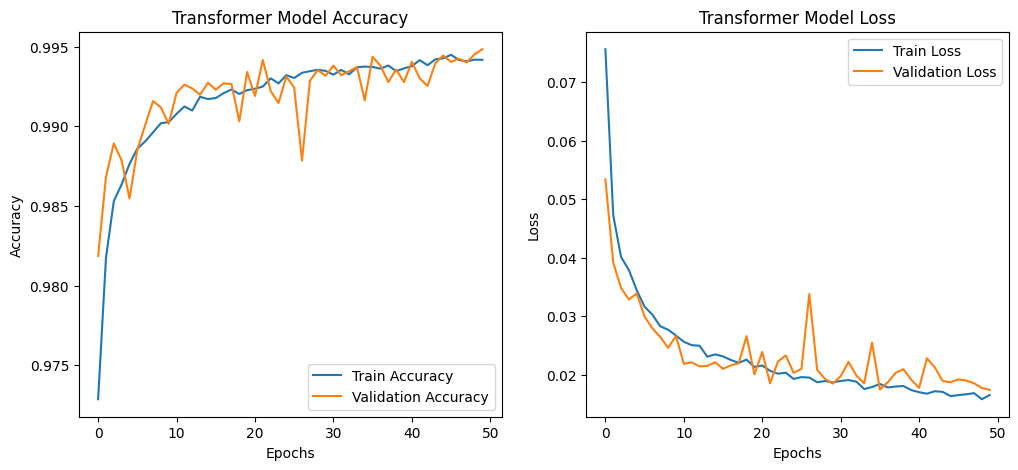

In [7]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Transformer Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Transformer Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

705/705 [==============================] - 1s 1ms/step


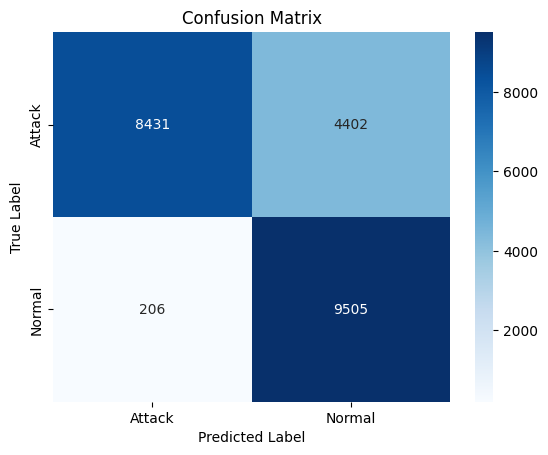

              precision    recall  f1-score   support

      Attack       0.98      0.66      0.79     12833
      Normal       0.68      0.98      0.80      9711

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.79     22544



In [8]:
# Confusion Matrix
y_pred = (transformer.predict(encoded_x_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))

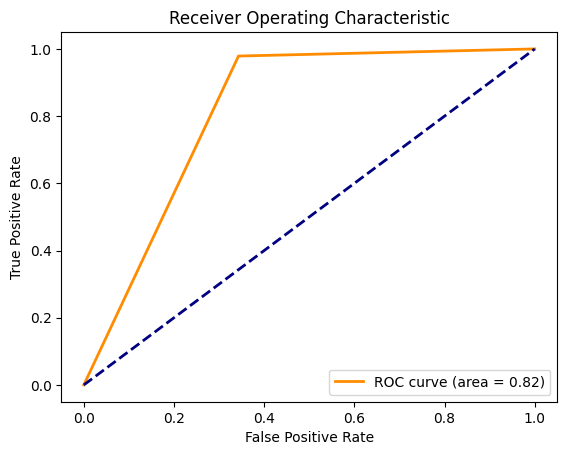

In [9]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Step 6: SHAP Analysis

In [ ]:
# Explain predictions with SHAP
explainer = shap.KernelExplainer(transformer.predict, encoded_x_test[:100])  # Use a subset for SHAP due to compute constraints
shap_values = explainer.shap_values(encoded_x_test[:100])

# Summary Plot
shap.summary_plot(shap_values[0], encoded_x_test[:100], feature_names=train.columns[:-1])

# Force Plot (First Instance)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], encoded_x_test[:1], feature_names=train.columns[:-1])

# Feature Importance Plot
shap.summary_plot(shap_values, encoded_x_test[:100], plot_type="bar", feature_names=train.columns[:-1])